<a href="https://colab.research.google.com/github/FutureOfTed/AI-class/blob/main/Week10/simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # StandardScaler import
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 사용자 지정 경로 (실제 UCI HAR Dataset 경로로 수정 필요)
DATASET_PATH = '/content/drive/MyDrive/data/UCI_HAR_Dataset/'

In [3]:
# 1. 데이터 로드 및 전처리 함수

def load_file(filepath):
    """지정된 경로의 텍스트 파일을 로드하여 NumPy 배열로 변환합니다."""
    try:
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Please check the dataset path structure.")
            return None
        # 공백(whitespace)을 구분자로 사용하여 데이터 로드
        dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return None
    return dataframe.values

def load_group(filenames, prefix=''):
    """여러 파일을 로드하여 하나의 3D NumPy 배열로 결합합니다."""
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        if data is not None:
            loaded.append(data)
        else:
            return None

    if not loaded: return None

    # 데이터의 마지막 차원(특징)을 기준으로 결합 (concatenate)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset(prefix=DATASET_PATH):
    """학습 및 테스트 데이터셋을 로드합니다."""
    # X 데이터셋 (시계열 특징) 로드
    filenames_train = [
        'train/Inertial Signals/total_acc_x_train.txt', 'train/Inertial Signals/total_acc_y_train.txt', 'train/Inertial Signals/total_acc_z_train.txt',
        'train/Inertial Signals/body_acc_x_train.txt', 'train/Inertial Signals/body_acc_y_train.txt', 'train/Inertial Signals/body_acc_z_train.txt',
        'train/Inertial Signals/body_gyro_x_train.txt', 'train/Inertial Signals/body_gyro_y_train.txt', 'train/Inertial Signals/body_gyro_z_train.txt'
    ]
    X_train = load_group(filenames_train, prefix)

    filenames_test = [
        'test/Inertial Signals/total_acc_x_test.txt', 'test/Inertial Signals/total_acc_y_test.txt', 'test/Inertial Signals/total_acc_z_test.txt',
        'test/Inertial Signals/body_acc_x_test.txt', 'test/Inertial Signals/body_acc_y_test.txt', 'test/Inertial Signals/body_acc_z_test.txt',
        'test/Inertial Signals/body_gyro_x_test.txt', 'test/Inertial Signals/body_gyro_y_test.txt', 'test/Inertial Signals/body_gyro_z_test.txt'
    ]
    X_test = load_group(filenames_test, prefix)

    if X_train is None or X_test is None:
        print("\n❌ 데이터 로드 실패. 경로와 파일 구조를 확인하십시오.")
        return None, None, None, None

    # y 데이터셋 (레이블) 로드 및 전처리
    y_train = load_file(prefix + 'train/y_train.txt')
    y_test = load_file(prefix + 'test/y_test.txt')

    if y_train is None or y_test is None: return None, None, None, None

    # 레이블 전처리: 1부터 시작하는 레이블을 0-오프셋으로 조정 후, One-Hot 인코딩
    y_train = y_train.flatten() - 1
    y_test = y_test.flatten() - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_test, y_test

def split_training_data(X_train, y_train, validation_split=0.2):
    """학습 데이터를 학습셋과 검증셋으로 분할합니다."""
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=validation_split, random_state=42, stratify=np.argmax(y_train, axis=1)
    )
    return X_train_split, X_val, y_train_split, y_val

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1973880680.py:10: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


In [4]:
# 2. 데이터 스케일링 함수
def scale_data(X_train, X_test):
    """
    3D 시계열 데이터를 2D로 변환하여 StandardScaler로 스케일링한 후,
    다시 3D 형태로 복원합니다.
    """
    n_samples_train, n_timesteps, n_features = X_train.shape
    n_samples_test, _, _ = X_test.shape

    # 2D 형태로 변환: (샘플 수 * 타임스텝) x 특징
    X_train_reshaped = X_train.reshape((-1, n_features))
    X_test_reshaped = X_test.reshape((-1, n_features))

    # StandardScaler 정의 및 학습 데이터에 fit
    scaler = StandardScaler()
    print("\n[Scaling] 학습 데이터셋에 StandardScaler를 fit합니다.")
    scaler.fit(X_train_reshaped)

    # 데이터 변환
    X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
    X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

    # 3D 형태로 복원: (샘플 수, 타임스텝, 특징)
    X_train_scaled = X_train_scaled_reshaped.reshape((n_samples_train, n_timesteps, n_features))
    X_test_scaled = X_test_scaled_reshaped.reshape((n_samples_test, n_timesteps, n_features))

    print(f"[Scaling] 스케일링 완료. Train Shape: {X_train_scaled.shape}, Test Shape: {X_test_scaled.shape}")
    return X_train_scaled, X_test_scaled

In [5]:
# 3. Simple 1D CNN 모델 정의 함수

def build_simple_cnn_model(n_timesteps, n_features, n_outputs):
    """단순화된 1D CNN 모델을 정의하고 컴파일합니다."""
    inputs = Input(shape=(n_timesteps, n_features))

    # 1D 컨볼루션 블록
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(conv1)
    drop = Dropout(0.5)(conv2)
    pool = MaxPooling1D(pool_size=2)(drop)

    # 분류기 블록
    flat = Flatten()(pool)
    dense_1 = Dense(100, activation='relu')(flat)
    outputs = Dense(n_outputs, activation='softmax')(dense_1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [7]:
# 4. 데이터 로드
X_train_full, y_train_full, X_test, y_test = load_dataset(DATASET_PATH)

In [8]:
# 5. 데이터 스케일링 적용
X_train_scaled, X_test_scaled = scale_data(X_train_full, X_test)


[Scaling] 학습 데이터셋에 StandardScaler를 fit합니다.
[Scaling] 스케일링 완료. Train Shape: (7352, 128, 9), Test Shape: (2947, 128, 9)


In [9]:
# 6. 학습 및 검증 데이터 분할 (스케일링된 데이터 사용)
X_train, X_val, y_train, y_val = split_training_data(X_train_scaled, y_train_full, validation_split=0.2)

In [10]:
# 7. 데이터 형태 확인
n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1]
print(f"\nTrain/Validation/Test 샘플 수: {X_train.shape[0]}/{X_val.shape[0]}/{X_test_scaled.shape[0]}")
print(f"입력 형태 (시퀀스, 특징): ({n_timesteps}, {n_features})")


Train/Validation/Test 샘플 수: 5881/1471/2947
입력 형태 (시퀀스, 특징): (128, 9)


In [11]:
# 8. 모델 정의 및 컴파일
model = build_simple_cnn_model(n_timesteps, n_features, n_outputs)
print("\n✅ Simple 1D CNN 모델 요약:")
model.summary()


✅ Simple 1D CNN 모델 요약:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       396,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,650 (1.57 MB)

 Trainable params: 411,650 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 9. 모델 학습
print("\n🚀 모델 학습 시작...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


🚀 모델 학습 시작...
Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7650 - loss: 0.5855 - val_accuracy: 0.9497 - val_loss: 0.1468
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9480 - loss: 0.1228 - val_accuracy: 0.9483 - val_loss: 0.2035
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9477 - loss: 0.1324 - val_accuracy: 0.9490 - val_loss: 0.1054
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9466 - loss: 0.1121 - val_accuracy: 0.9572 - val_loss: 0.0983
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9613 - loss: 0.0833 - val_accuracy: 0.9490 - val_loss: 0.1303
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9613 - loss: 0.0873 - val_accuracy: 0.9626 - val_loss: 0.1029
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9592 - loss: 0.0845 - val_accuracy: 0.9599 - val_loss: 0.0899
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9668 - loss: 0.0732 

/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2692107897.py:21: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from 

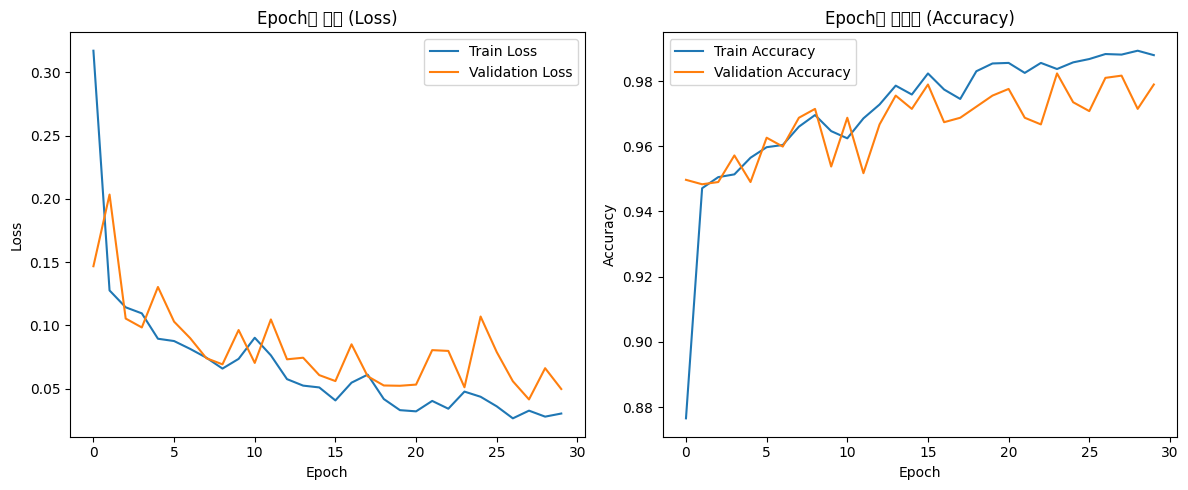

In [13]:
# 10. 학습 과정 시각화
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch별 손실 (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch별 정확도 (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# 11. 모델 평가 (테스트 데이터셋)
print("\n📉 테스트 데이터셋으로 모델 평가...")
# 스케일링된 테스트 데이터 사용
loss, test_accuracy = model.evaluate(X_test_scaled, y_test, batch_size=32, verbose=0)


📉 테스트 데이터셋으로 모델 평가...


In [16]:
# 12. F1-Score 및 성능 보고서 출력
y_pred = model.predict(X_test_scaled, verbose=0)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

In [17]:
# 13. F1-Score 계산
weighted_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

In [18]:
# 14. 최종 평가 지표
print("\n--- 최종 평가 지표 (Simple 1D CNN with Scaling) ---")
print(f"Test Loss: {loss:.4f}")
print(f"Accuracy (정확도): {test_accuracy*100:.2f}%")
print(f"Weighted F1-Score (가중 F1): {weighted_f1:.4f}")
print(f"Macro F1-Score (매크로 F1): {macro_f1:.4f}")


--- 최종 평가 지표 (Simple 1D CNN with Scaling) ---
Test Loss: 0.5741
Accuracy (정확도): 92.43%
Weighted F1-Score (가중 F1): 0.9237
Macro F1-Score (매크로 F1): 0.9237


In [19]:
# 15. 클래스별 상세 지표
print("\n--- Classification Report (클래스별 상세 지표) ---")
# 레이블 이름: 0:Walking, 1:Upstairs, 2:Downstairs, 3:Sitting, 4:Standing, 5:Laying
target_names = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']
print(classification_report(y_test_labels, y_pred_labels, target_names=target_names))


--- Classification Report (클래스별 상세 지표) ---
              precision    recall  f1-score   support

     Walking       0.98      0.94      0.96       496
    Upstairs       0.95      0.94      0.94       471
  Downstairs       0.89      1.00      0.94       420
     Sitting       0.87      0.79      0.83       491
    Standing       0.86      0.89      0.87       532
      Laying       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947



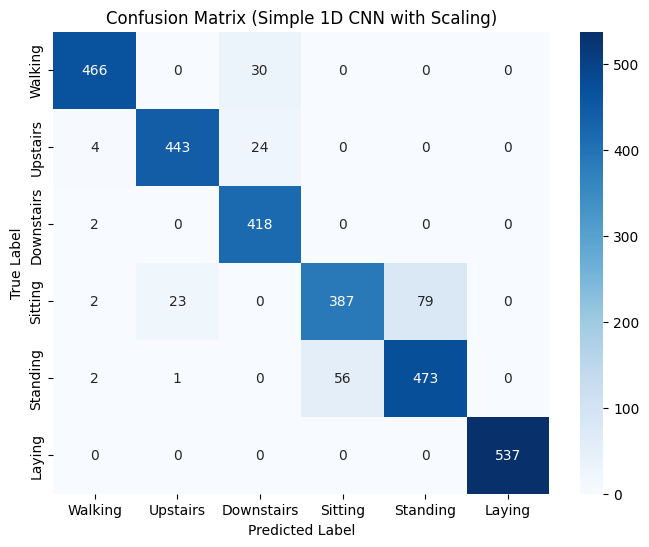

In [20]:
# 16. 혼동 행렬 시각화
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Simple 1D CNN with Scaling)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()